# Tunable Dual-Polarity Time-to-Digital Converter

In [30]:
import burn 
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

## Load the PicoRV adjacent to the TDC

In [31]:
design = burn.z1.picorv.picorv32.baseOverlay("picorv32.bit")

# Bring the rising transition into the capture window
Gradually shift theta untill the popcount of the rising transition has entered the carry chain

In [32]:
while True:
    buf = design.run(6)
    design.chain0.phaseBump.down()
    if (np.mean(burn.parse.Trace.CombinedTrace(buf).pos.pop) != 64.0):
        break

for bump in range(10):
    design.chain0.phaseBump.down()

## Infinite Running AES on PicoRV32

In [34]:
%%riscvc aes design.processor

// All credit: https://github.com/kokke/tiny-AES-c

#define Nb 4
#define Nk 4
#define KEYLEN 16
#define Nr 10
#ifndef MULTIPLY_AS_A_FUNCTION
  #define MULTIPLY_AS_A_FUNCTION 0
#endif

typedef unsigned char uint8_t;
typedef unsigned short uint16_t;
typedef unsigned long uint32_t;
typedef unsigned long long uint64_t;
typedef uint32_t size_t;
typedef uint32_t uintptr_t;
typedef uint32_t size_t;

typedef uint8_t state_t[4][4];
static state_t* state;

static uint8_t RoundKey[176];

static const uint8_t* Key;

static uint8_t* Iv;

static const uint8_t sbox[256] =   {
  //0     1    2      3     4    5     6     7      8    9     A      B    C     D     E     F
  0x63, 0x7c, 0x77, 0x7b, 0xf2, 0x6b, 0x6f, 0xc5, 0x30, 0x01, 0x67, 0x2b, 0xfe, 0xd7, 0xab, 0x76,
  0xca, 0x82, 0xc9, 0x7d, 0xfa, 0x59, 0x47, 0xf0, 0xad, 0xd4, 0xa2, 0xaf, 0x9c, 0xa4, 0x72, 0xc0,
  0xb7, 0xfd, 0x93, 0x26, 0x36, 0x3f, 0xf7, 0xcc, 0x34, 0xa5, 0xe5, 0xf1, 0x71, 0xd8, 0x31, 0x15,
  0x04, 0xc7, 0x23, 0xc3, 0x18, 0x96, 0x05, 0x9a, 0x07, 0x12, 0x80, 0xe2, 0xeb, 0x27, 0xb2, 0x75,
  0x09, 0x83, 0x2c, 0x1a, 0x1b, 0x6e, 0x5a, 0xa0, 0x52, 0x3b, 0xd6, 0xb3, 0x29, 0xe3, 0x2f, 0x84,
  0x53, 0xd1, 0x00, 0xed, 0x20, 0xfc, 0xb1, 0x5b, 0x6a, 0xcb, 0xbe, 0x39, 0x4a, 0x4c, 0x58, 0xcf,
  0xd0, 0xef, 0xaa, 0xfb, 0x43, 0x4d, 0x33, 0x85, 0x45, 0xf9, 0x02, 0x7f, 0x50, 0x3c, 0x9f, 0xa8,
  0x51, 0xa3, 0x40, 0x8f, 0x92, 0x9d, 0x38, 0xf5, 0xbc, 0xb6, 0xda, 0x21, 0x10, 0xff, 0xf3, 0xd2,
  0xcd, 0x0c, 0x13, 0xec, 0x5f, 0x97, 0x44, 0x17, 0xc4, 0xa7, 0x7e, 0x3d, 0x64, 0x5d, 0x19, 0x73,
  0x60, 0x81, 0x4f, 0xdc, 0x22, 0x2a, 0x90, 0x88, 0x46, 0xee, 0xb8, 0x14, 0xde, 0x5e, 0x0b, 0xdb,
  0xe0, 0x32, 0x3a, 0x0a, 0x49, 0x06, 0x24, 0x5c, 0xc2, 0xd3, 0xac, 0x62, 0x91, 0x95, 0xe4, 0x79,
  0xe7, 0xc8, 0x37, 0x6d, 0x8d, 0xd5, 0x4e, 0xa9, 0x6c, 0x56, 0xf4, 0xea, 0x65, 0x7a, 0xae, 0x08,
  0xba, 0x78, 0x25, 0x2e, 0x1c, 0xa6, 0xb4, 0xc6, 0xe8, 0xdd, 0x74, 0x1f, 0x4b, 0xbd, 0x8b, 0x8a,
  0x70, 0x3e, 0xb5, 0x66, 0x48, 0x03, 0xf6, 0x0e, 0x61, 0x35, 0x57, 0xb9, 0x86, 0xc1, 0x1d, 0x9e,
  0xe1, 0xf8, 0x98, 0x11, 0x69, 0xd9, 0x8e, 0x94, 0x9b, 0x1e, 0x87, 0xe9, 0xce, 0x55, 0x28, 0xdf,
  0x8c, 0xa1, 0x89, 0x0d, 0xbf, 0xe6, 0x42, 0x68, 0x41, 0x99, 0x2d, 0x0f, 0xb0, 0x54, 0xbb, 0x16 };

static const uint8_t rsbox[256] =
{ 0x52, 0x09, 0x6a, 0xd5, 0x30, 0x36, 0xa5, 0x38, 0xbf, 0x40, 0xa3, 0x9e, 0x81, 0xf3, 0xd7, 0xfb,
  0x7c, 0xe3, 0x39, 0x82, 0x9b, 0x2f, 0xff, 0x87, 0x34, 0x8e, 0x43, 0x44, 0xc4, 0xde, 0xe9, 0xcb,
  0x54, 0x7b, 0x94, 0x32, 0xa6, 0xc2, 0x23, 0x3d, 0xee, 0x4c, 0x95, 0x0b, 0x42, 0xfa, 0xc3, 0x4e,
  0x08, 0x2e, 0xa1, 0x66, 0x28, 0xd9, 0x24, 0xb2, 0x76, 0x5b, 0xa2, 0x49, 0x6d, 0x8b, 0xd1, 0x25,
  0x72, 0xf8, 0xf6, 0x64, 0x86, 0x68, 0x98, 0x16, 0xd4, 0xa4, 0x5c, 0xcc, 0x5d, 0x65, 0xb6, 0x92,
  0x6c, 0x70, 0x48, 0x50, 0xfd, 0xed, 0xb9, 0xda, 0x5e, 0x15, 0x46, 0x57, 0xa7, 0x8d, 0x9d, 0x84,
  0x90, 0xd8, 0xab, 0x00, 0x8c, 0xbc, 0xd3, 0x0a, 0xf7, 0xe4, 0x58, 0x05, 0xb8, 0xb3, 0x45, 0x06,
  0xd0, 0x2c, 0x1e, 0x8f, 0xca, 0x3f, 0x0f, 0x02, 0xc1, 0xaf, 0xbd, 0x03, 0x01, 0x13, 0x8a, 0x6b,
  0x3a, 0x91, 0x11, 0x41, 0x4f, 0x67, 0xdc, 0xea, 0x97, 0xf2, 0xcf, 0xce, 0xf0, 0xb4, 0xe6, 0x73,
  0x96, 0xac, 0x74, 0x22, 0xe7, 0xad, 0x35, 0x85, 0xe2, 0xf9, 0x37, 0xe8, 0x1c, 0x75, 0xdf, 0x6e,
  0x47, 0xf1, 0x1a, 0x71, 0x1d, 0x29, 0xc5, 0x89, 0x6f, 0xb7, 0x62, 0x0e, 0xaa, 0x18, 0xbe, 0x1b,
  0xfc, 0x56, 0x3e, 0x4b, 0xc6, 0xd2, 0x79, 0x20, 0x9a, 0xdb, 0xc0, 0xfe, 0x78, 0xcd, 0x5a, 0xf4,
  0x1f, 0xdd, 0xa8, 0x33, 0x88, 0x07, 0xc7, 0x31, 0xb1, 0x12, 0x10, 0x59, 0x27, 0x80, 0xec, 0x5f,
  0x60, 0x51, 0x7f, 0xa9, 0x19, 0xb5, 0x4a, 0x0d, 0x2d, 0xe5, 0x7a, 0x9f, 0x93, 0xc9, 0x9c, 0xef,
  0xa0, 0xe0, 0x3b, 0x4d, 0xae, 0x2a, 0xf5, 0xb0, 0xc8, 0xeb, 0xbb, 0x3c, 0x83, 0x53, 0x99, 0x61,
  0x17, 0x2b, 0x04, 0x7e, 0xba, 0x77, 0xd6, 0x26, 0xe1, 0x69, 0x14, 0x63, 0x55, 0x21, 0x0c, 0x7d };

static const uint8_t Rcon[255] = {
  0x8d, 0x01, 0x02, 0x04, 0x08, 0x10, 0x20, 0x40, 0x80, 0x1b, 0x36, 0x6c, 0xd8, 0xab, 0x4d, 0x9a, 
  0x2f, 0x5e, 0xbc, 0x63, 0xc6, 0x97, 0x35, 0x6a, 0xd4, 0xb3, 0x7d, 0xfa, 0xef, 0xc5, 0x91, 0x39, 
  0x72, 0xe4, 0xd3, 0xbd, 0x61, 0xc2, 0x9f, 0x25, 0x4a, 0x94, 0x33, 0x66, 0xcc, 0x83, 0x1d, 0x3a, 
  0x74, 0xe8, 0xcb, 0x8d, 0x01, 0x02, 0x04, 0x08, 0x10, 0x20, 0x40, 0x80, 0x1b, 0x36, 0x6c, 0xd8, 
  0xab, 0x4d, 0x9a, 0x2f, 0x5e, 0xbc, 0x63, 0xc6, 0x97, 0x35, 0x6a, 0xd4, 0xb3, 0x7d, 0xfa, 0xef, 
  0xc5, 0x91, 0x39, 0x72, 0xe4, 0xd3, 0xbd, 0x61, 0xc2, 0x9f, 0x25, 0x4a, 0x94, 0x33, 0x66, 0xcc, 
  0x83, 0x1d, 0x3a, 0x74, 0xe8, 0xcb, 0x8d, 0x01, 0x02, 0x04, 0x08, 0x10, 0x20, 0x40, 0x80, 0x1b, 
  0x36, 0x6c, 0xd8, 0xab, 0x4d, 0x9a, 0x2f, 0x5e, 0xbc, 0x63, 0xc6, 0x97, 0x35, 0x6a, 0xd4, 0xb3, 
  0x7d, 0xfa, 0xef, 0xc5, 0x91, 0x39, 0x72, 0xe4, 0xd3, 0xbd, 0x61, 0xc2, 0x9f, 0x25, 0x4a, 0x94, 
  0x33, 0x66, 0xcc, 0x83, 0x1d, 0x3a, 0x74, 0xe8, 0xcb, 0x8d, 0x01, 0x02, 0x04, 0x08, 0x10, 0x20, 
  0x40, 0x80, 0x1b, 0x36, 0x6c, 0xd8, 0xab, 0x4d, 0x9a, 0x2f, 0x5e, 0xbc, 0x63, 0xc6, 0x97, 0x35, 
  0x6a, 0xd4, 0xb3, 0x7d, 0xfa, 0xef, 0xc5, 0x91, 0x39, 0x72, 0xe4, 0xd3, 0xbd, 0x61, 0xc2, 0x9f, 
  0x25, 0x4a, 0x94, 0x33, 0x66, 0xcc, 0x83, 0x1d, 0x3a, 0x74, 0xe8, 0xcb, 0x8d, 0x01, 0x02, 0x04, 
  0x08, 0x10, 0x20, 0x40, 0x80, 0x1b, 0x36, 0x6c, 0xd8, 0xab, 0x4d, 0x9a, 0x2f, 0x5e, 0xbc, 0x63, 
  0xc6, 0x97, 0x35, 0x6a, 0xd4, 0xb3, 0x7d, 0xfa, 0xef, 0xc5, 0x91, 0x39, 0x72, 0xe4, 0xd3, 0xbd, 
  0x61, 0xc2, 0x9f, 0x25, 0x4a, 0x94, 0x33, 0x66, 0xcc, 0x83, 0x1d, 0x3a, 0x74, 0xe8, 0xcb  };


/*****************************************************************************/
/* Private functions:                                                        */
/*****************************************************************************/
static uint8_t getSBoxValue(uint8_t num)
{
  return sbox[num];
}

static uint8_t getSBoxInvert(uint8_t num)
{
  return rsbox[num];
}

// This function produces Nb(Nr+1) round keys. The round keys are used in each round to decrypt the states. 
static void KeyExpansion(void)
{
  uint32_t i, j, k;
  uint8_t tempa[4]; // Used for the column/row operations
  
  // The first round key is the key itself.
  for(i = 0; i < Nk; ++i)
  {
    RoundKey[(i * 4) + 0] = Key[(i * 4) + 0];
    RoundKey[(i * 4) + 1] = Key[(i * 4) + 1];
    RoundKey[(i * 4) + 2] = Key[(i * 4) + 2];
    RoundKey[(i * 4) + 3] = Key[(i * 4) + 3];
  }

  // All other round keys are found from the previous round keys.
  for(; (i < (Nb * (Nr + 1))); ++i)
  {
    for(j = 0; j < 4; ++j)
    {
      tempa[j]=RoundKey[(i-1) * 4 + j];
    }
    if (i % Nk == 0)
    {
      // This function rotates the 4 bytes in a word to the left once.
      // [a0,a1,a2,a3] becomes [a1,a2,a3,a0]

      // Function RotWord()
      {
        k = tempa[0];
        tempa[0] = tempa[1];
        tempa[1] = tempa[2];
        tempa[2] = tempa[3];
        tempa[3] = k;
      }

      // SubWord() is a function that takes a four-byte input word and 
      // applies the S-box to each of the four bytes to produce an output word.

      // Function Subword()
      {
        tempa[0] = getSBoxValue(tempa[0]);
        tempa[1] = getSBoxValue(tempa[1]);
        tempa[2] = getSBoxValue(tempa[2]);
        tempa[3] = getSBoxValue(tempa[3]);
      }

      tempa[0] =  tempa[0] ^ Rcon[i/Nk];
    }
    else if (Nk > 6 && i % Nk == 4)
    {
      // Function Subword()
      {
        tempa[0] = getSBoxValue(tempa[0]);
        tempa[1] = getSBoxValue(tempa[1]);
        tempa[2] = getSBoxValue(tempa[2]);
        tempa[3] = getSBoxValue(tempa[3]);
      }
    }
    RoundKey[i * 4 + 0] = RoundKey[(i - Nk) * 4 + 0] ^ tempa[0];
    RoundKey[i * 4 + 1] = RoundKey[(i - Nk) * 4 + 1] ^ tempa[1];
    RoundKey[i * 4 + 2] = RoundKey[(i - Nk) * 4 + 2] ^ tempa[2];
    RoundKey[i * 4 + 3] = RoundKey[(i - Nk) * 4 + 3] ^ tempa[3];
  }
}

// This function adds the round key to state.
// The round key is added to the state by an XOR function.
static void AddRoundKey(uint8_t round)
{
  uint8_t i,j;
  for(i=0;i<4;++i)
  {
    for(j = 0; j < 4; ++j)
    {
      (*state)[i][j] ^= RoundKey[round * Nb * 4 + i * Nb + j];
    }
  }
}

// The SubBytes Function Substitutes the values in the
// state matrix with values in an S-box.
static void SubBytes(void)
{
  uint8_t i, j;
  for(i = 0; i < 4; ++i)
  {
    for(j = 0; j < 4; ++j)
    {
      (*state)[j][i] = getSBoxValue((*state)[j][i]);
    }
  }
}

// The ShiftRows() function shifts the rows in the state to the left.
// Each row is shifted with different offset.
// Offset = Row number. So the first row is not shifted.
static void ShiftRows(void)
{
  uint8_t temp;

  // Rotate first row 1 columns to left  
  temp           = (*state)[0][1];
  (*state)[0][1] = (*state)[1][1];
  (*state)[1][1] = (*state)[2][1];
  (*state)[2][1] = (*state)[3][1];
  (*state)[3][1] = temp;

  // Rotate second row 2 columns to left  
  temp           = (*state)[0][2];
  (*state)[0][2] = (*state)[2][2];
  (*state)[2][2] = temp;

  temp       = (*state)[1][2];
  (*state)[1][2] = (*state)[3][2];
  (*state)[3][2] = temp;

  // Rotate third row 3 columns to left
  temp       = (*state)[0][3];
  (*state)[0][3] = (*state)[3][3];
  (*state)[3][3] = (*state)[2][3];
  (*state)[2][3] = (*state)[1][3];
  (*state)[1][3] = temp;
}

static uint8_t xtime(uint8_t x)
{
  return ((x<<1) ^ (((x>>7) & 1) * 0x1b));
}

// MixColumns function mixes the columns of the state matrix
static void MixColumns(void)
{
  uint8_t i;
  uint8_t Tmp,Tm,t;
  for(i = 0; i < 4; ++i)
  {  
    t   = (*state)[i][0];
    Tmp = (*state)[i][0] ^ (*state)[i][1] ^ (*state)[i][2] ^ (*state)[i][3] ;
    Tm  = (*state)[i][0] ^ (*state)[i][1] ; Tm = xtime(Tm);  (*state)[i][0] ^= Tm ^ Tmp ;
    Tm  = (*state)[i][1] ^ (*state)[i][2] ; Tm = xtime(Tm);  (*state)[i][1] ^= Tm ^ Tmp ;
    Tm  = (*state)[i][2] ^ (*state)[i][3] ; Tm = xtime(Tm);  (*state)[i][2] ^= Tm ^ Tmp ;
    Tm  = (*state)[i][3] ^ t ;        Tm = xtime(Tm);  (*state)[i][3] ^= Tm ^ Tmp ;
  }
}

// Multiply is used to multiply numbers in the field GF(2^8)
#if MULTIPLY_AS_A_FUNCTION
static uint8_t Multiply(uint8_t x, uint8_t y)
{
  return (((y & 1) * x) ^
       ((y>>1 & 1) * xtime(x)) ^
       ((y>>2 & 1) * xtime(xtime(x))) ^
       ((y>>3 & 1) * xtime(xtime(xtime(x)))) ^
       ((y>>4 & 1) * xtime(xtime(xtime(xtime(x))))));
  }
#else
#define Multiply(x, y)                                \
      (  ((y & 1) * x) ^                              \
      ((y>>1 & 1) * xtime(x)) ^                       \
      ((y>>2 & 1) * xtime(xtime(x))) ^                \
      ((y>>3 & 1) * xtime(xtime(xtime(x)))) ^         \
      ((y>>4 & 1) * xtime(xtime(xtime(xtime(x))))))   \

#endif


static void InvMixColumns(void)
{
  int i;
  uint8_t a,b,c,d;
  for(i=0;i<4;++i)
  { 
    a = (*state)[i][0];
    b = (*state)[i][1];
    c = (*state)[i][2];
    d = (*state)[i][3];

    (*state)[i][0] = Multiply(a, 0x0e) ^ Multiply(b, 0x0b) ^ Multiply(c, 0x0d) ^ Multiply(d, 0x09);
    (*state)[i][1] = Multiply(a, 0x09) ^ Multiply(b, 0x0e) ^ Multiply(c, 0x0b) ^ Multiply(d, 0x0d);
    (*state)[i][2] = Multiply(a, 0x0d) ^ Multiply(b, 0x09) ^ Multiply(c, 0x0e) ^ Multiply(d, 0x0b);
    (*state)[i][3] = Multiply(a, 0x0b) ^ Multiply(b, 0x0d) ^ Multiply(c, 0x09) ^ Multiply(d, 0x0e);
  }
}


// The SubBytes Function Substitutes the values in the
// state matrix with values in an S-box.
static void InvSubBytes(void)
{
  uint8_t i,j;
  for(i=0;i<4;++i)
  {
    for(j=0;j<4;++j)
    {
      (*state)[j][i] = getSBoxInvert((*state)[j][i]);
    }
  }
}

static void InvShiftRows(void)
{
  uint8_t temp;

  // Rotate first row 1 columns to right  
  temp=(*state)[3][1];
  (*state)[3][1]=(*state)[2][1];
  (*state)[2][1]=(*state)[1][1];
  (*state)[1][1]=(*state)[0][1];
  (*state)[0][1]=temp;

  // Rotate second row 2 columns to right 
  temp=(*state)[0][2];
  (*state)[0][2]=(*state)[2][2];
  (*state)[2][2]=temp;

  temp=(*state)[1][2];
  (*state)[1][2]=(*state)[3][2];
  (*state)[3][2]=temp;

  // Rotate third row 3 columns to right
  temp=(*state)[0][3];
  (*state)[0][3]=(*state)[1][3];
  (*state)[1][3]=(*state)[2][3];
  (*state)[2][3]=(*state)[3][3];
  (*state)[3][3]=temp;
}


// Cipher is the main function that encrypts the PlainText.
static void Cipher(void)
{
  uint8_t round = 0;

  // Add the First round key to the state before starting the rounds.
  AddRoundKey(0); 
  
  // There will be Nr rounds. nr = 10
  // The first Nr-1 rounds are identical.
  // These Nr-1 rounds are executed in the loop below.
  for(round = 1; round < Nr; ++round)
  {   
    SubBytes();
    ShiftRows();
    MixColumns();
    AddRoundKey(round);
  }
    
  SubBytes();
  ShiftRows();
  AddRoundKey(Nr);
}

static void InvCipher(void)
{
  uint8_t round=0;
  AddRoundKey(Nr); 

  for(round=Nr-1;round>0;round--)
  {
    InvShiftRows();
    InvSubBytes();
    AddRoundKey(round);
    InvMixColumns();
  }

  InvShiftRows();
  InvSubBytes();
  AddRoundKey(0);
}

static void BlockCopy(uint8_t* output, uint8_t* input)
{
  uint8_t i;
  for (i=0;i<KEYLEN;++i)
  {
    output[i] = input[i];
  }
}

void AES128_ECB_encrypt(uint8_t* input, const uint8_t* key, uint8_t* output)
{
  // Copy input to output, and work in-memory on output
  BlockCopy(output, input);
  state = (state_t*)output;

  Key = key;
  KeyExpansion();

  // The next function call encrypts the PlainText with the Key using AES algorithm.
  Cipher();
}

void AES128_ECB_decrypt(uint8_t* input, const uint8_t* key, uint8_t *output)
{
  // Copy input to output, and work in-memory on output
  BlockCopy(output, input);
  state = (state_t*)output;

  // The KeyExpansion routine must be called before encryption.
  Key = key;
  KeyExpansion();

  InvCipher();
}


static void XorWithIv(uint8_t* buf)
{
  uint8_t i;
  for(i = 0; i < KEYLEN; ++i)
  {
    buf[i] ^= Iv[i];
  }
}

void *memset(void *s, int c, size_t n)
{
    unsigned char* p=s;
    while(n--)
        *p++ = (unsigned char)c;
    return s;
}

void *memcpy(void *dest, const void *src, size_t n)
{
    char *dp = dest;
    const char *sp = src;
    while (n--)
        *dp++ = *sp++;
    return dest;
}

int strncmp(const char* s1, const char* s2, size_t n)
{
    while(n--)
        if(*s1++!=*s2++)
            return *(unsigned char*)(s1 - 1) - *(unsigned char*)(s2 - 1);
    return 0;
}

int main(int argc, char ** argv){
    uint8_t key[] = {0x2b, 0x7e, 0x15, 0x16, 0x28, 0xae, 0xd2, 0xa6, 0xab, 0xf7, 0x15, 0x88, 0x09, 0xcf, 0x4f, 0x3c};
    uint8_t in[]  = {0x6b, 0xc1, 0xbe, 0xe2, 0x2e, 0x40, 0x9f, 0x96, 0xe9, 0x3d, 0x7e, 0x11, 0x73, 0x93, 0x17, 0x2a};
    uint8_t out[] = {0x3a, 0xd7, 0x7b, 0xb4, 0x0d, 0x7a, 0x36, 0x60, 0xa8, 0x9e, 0xca, 0xf3, 0x24, 0x66, 0xef, 0x97};
    uint8_t buffer[16];
    for(;;) AES128_ECB_encrypt(in, key, buffer);
    return 1;
}

## Measure Background phi Sweep

In [35]:
base_sweep = np.zeros(2688)
for phi in tqdm(range(2688)):
    buf = design.run(6)
    base_sweep[phi] = np.mean(burn.parse.Trace.CombinedTrace(buf).pos.pop)
    design.bumper.phase_bump_target_sensor.down()

    
for phi in range(2688):
    design.bumper.phase_bump_target_sensor.up()

100%|██████████| 2688/2688 [01:15<00:00, 35.57it/s]


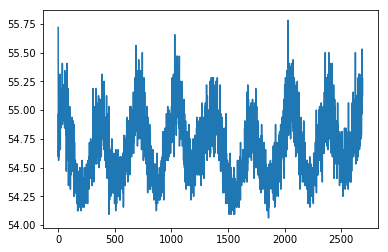

In [36]:
plt.plot(base_sweep)

## Measure Active AES phi Sweep

In [37]:
args = np.array([], np.int32)
design.processor.launch(aes, args)

In [38]:
pico_sweep = np.zeros(2688)
for phi in tqdm(range(2688)):
    buf = design.run(8)
    pico_sweep[phi] = np.mean(burn.parse.Trace.CombinedTrace(buf).pos.pop)
    design.bumper.phase_bump_target_sensor.down()

100%|██████████| 2688/2688 [01:46<00:00, 25.21it/s]


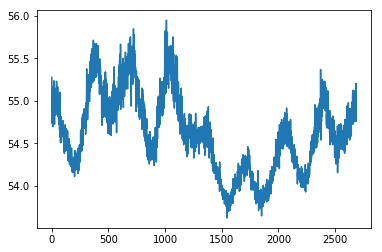

In [39]:
plt.plot(pico_sweep)

## Isolating PicoRV Signal 

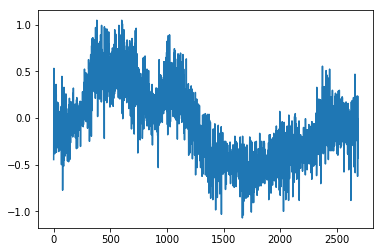

In [40]:
plt.plot(pico_sweep - base_sweep)